### Data PreProssing 
explained: `2_Data PreProcessing.ipynb`

Dataset: [Gamma Telescope](https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope), folder: magic+gamma+telescope

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.read_csv("magic+gamma+telescope/magic04.data", names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [3]:
# g = 1 , h = 0 
df["class"] = (df["class"] == "g").astype(int)

In [4]:
df

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,0
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,0
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,0
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,0


In [6]:
# train, valid, test split
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [7]:
# standardization
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [8]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

____
____

# Neutral Network
Basic Explanation **`Neural Networks_basics.docx`**

<img src="img/Neutral Network.png" width="700" height="700">

In [40]:
import tensorflow as tf

In [52]:
#Verifying TensorFlow
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))
print(tf.config.list_physical_devices('GPU'))

2.16.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


In [53]:
# Function to plot training history
def plot_history(history):
    # Create subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot training and validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.set_title('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot training and validation accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Show the plot
    plt.show()

In [54]:
# Function to train the neural network model
def train_model(X_train, y_train, num_nodes, dropout_prob, learning_rate, batch_size, epochs):
    # Define the neural network architecture
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy',
                    metrics=['accuracy'])
    
    # Train the model
    history = nn_model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0 #verbose=0, to only display plot training history
    )

    return nn_model, history

In [55]:
# Initialize variables for tracking the best model
least_val_loss = float('inf')
least_loss_model = None
epochs = 100

Tuning Hyperparameters: num_nodes=16, dropout_prob=0, learning_rate=0.01, batch_size=32


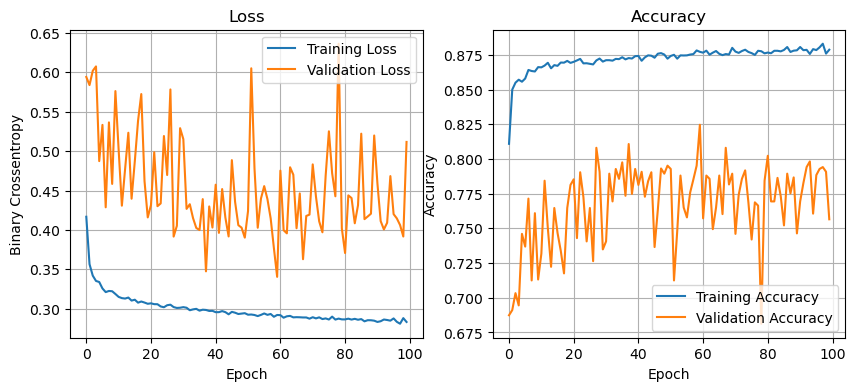

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.3532
Tuning Hyperparameters: num_nodes=16, dropout_prob=0, learning_rate=0.01, batch_size=64


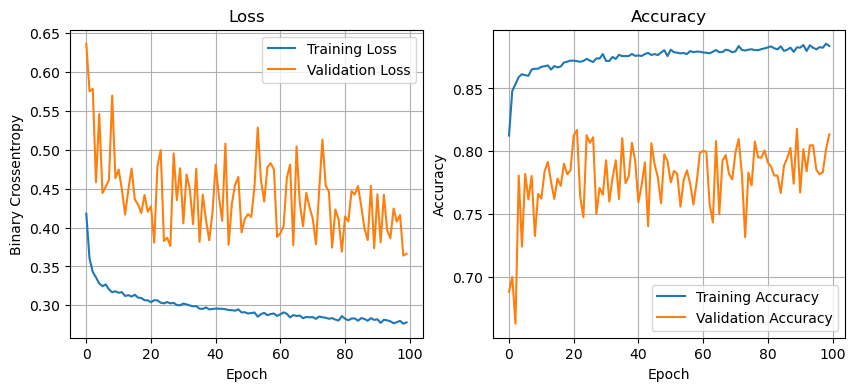

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8672 - loss: 0.3147
Tuning Hyperparameters: num_nodes=16, dropout_prob=0, learning_rate=0.01, batch_size=128


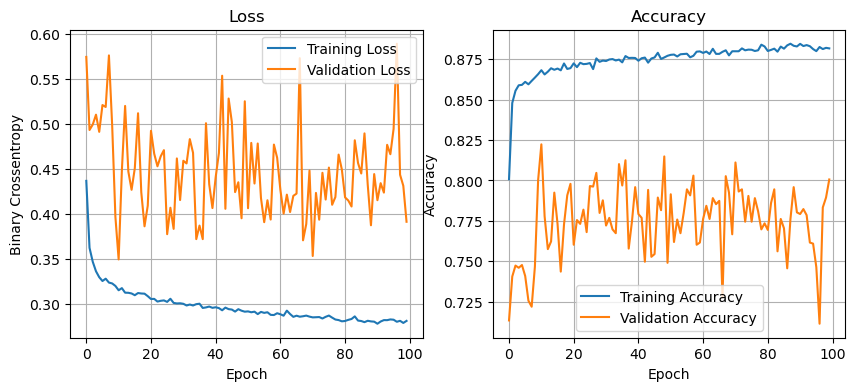

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8720 - loss: 0.3273
Tuning Hyperparameters: num_nodes=16, dropout_prob=0, learning_rate=0.005, batch_size=32


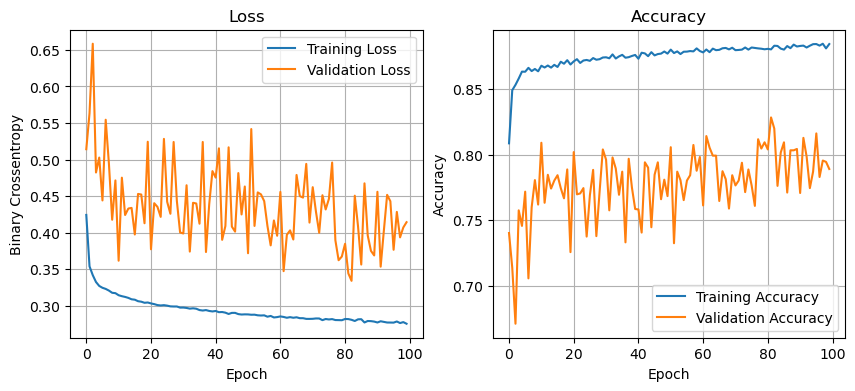

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8738 - loss: 0.3205
Tuning Hyperparameters: num_nodes=16, dropout_prob=0, learning_rate=0.005, batch_size=64


KeyboardInterrupt: 

In [56]:
# Hyperparameter tuning loop
for num_nodes in [16, 32, 64]:
    for dropout_prob in [0, 0.2]:
        for learning_rate in [0.01, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                print(f"Tuning Hyperparameters: num_nodes={num_nodes}, dropout_prob={dropout_prob}, learning_rate={learning_rate}, batch_size={batch_size}")
                
                # Train the model
                model, history = train_model(X_train, y_train, num_nodes, dropout_prob, learning_rate, batch_size, epochs)
                
                # Plot the training history
                plot_history(history)
                
                # Evaluate the model on the validation data
                val_loss = model.evaluate(X_valid, y_valid)[0]
                
                # Update the best model if the current validation loss is the least
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

Training interrupted

In [62]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [63]:
y_pred

array([0, 1, 0, ..., 1, 1, 1])

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1312
           1       0.88      0.92      0.90      2492

    accuracy                           0.87      3804
   macro avg       0.86      0.84      0.85      3804
weighted avg       0.86      0.87      0.86      3804



 >accuracy - 87% (👍)

___
# Performance evaluation

## Confusion Matrix

In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
cm = confusion_matrix(y_test, y_pred)

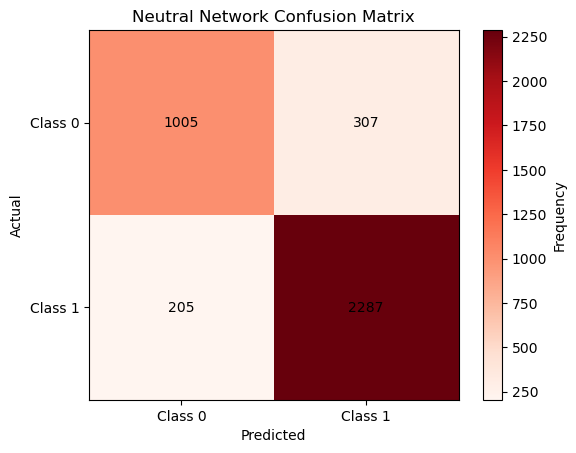

In [65]:
# confusion matrix as heatmap
plt.imshow(cm, cmap='Reds', interpolation='nearest')
plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
plt.yticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])

plt.colorbar(label='Frequency')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neutral Network Confusion Matrix')

# correcting the annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black')
        
plt.show()